# Agrupamiento por generos de canciones a partir de datos obtenidos en la API de Spotify 

## Introduccion

Los metodos de aprendizaje no supervisado nos permiten descubrir informacion previamente desconocida, por lo que son una herramienta poderosa en cuanto a la generacion de conocimiento se refiere. Uno de los metodos mas utiles y populares de este tipo de aplicaciones del Machine Learning, es la clusterizacion, en español agrupamiento. Esta tecnica consiste, como su nombre lo indica, en agrupar poblaciones de individuos basados en algun tipo de distancia, de modo que individuos cercanos pertenezcan al mismo grupo una vez calculadas dichas distancias. El presente trabajo tiene por objetivo agrupar distintas canciones sobre las cuales se tienen datos tanto de alto nivel, es decir metricas de conceptos abstractos, asi como de bajo nivel, es decir, datos mas sonoros. A partir de estas agrupaciones se pretende deducir el genero musical al cual pertenecen, logrando asi una manera de clasificarlas a partir de los atributos que las caracterizan.

## Metodos

Se utilizara para clusterizar a las canciones el algoritmo kmeans de la libreria sklearn. Asi mismo, tambien se utilizara para evaluar la calidad de estus clusters los indices Rand y Van Dongen.

In [39]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn import model_selection # Números y Datos
import numpy as np
import pandas as pd
import ast # Archivos
import urllib.request
import glob
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster,single
import scipy.cluster.hierarchy as h
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.stats import boxcox
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE
from sklearn.preprocessing import LabelEncoder
import pylab
from umap import UMAP
import pylab
# Machine learning
# importar los paquetes para clustering

## Carga de datos

La informacion sobre obtenida de la API, se encuentra contenida en tres fuentes. la primera es un archivo de metadatos que contiene informacion descriptiva de la cancion tales como el artista y el genero. La segunda contiene infromacion de alto nivel sobre el audio de la cancion, tal como la acusticidad o la energia. Por ultimo esta una coleccion de archivos que contienen datos de bajo nivel, es decir, variables numericas relativas a las carectiristicas sonoras de la cancion segmentada en distintos espacios de tiempo. Como primer paso procedemos a cargar estos datos y almacenarlos en un Dataframe de Pandas:

In [40]:
meta = pd.read_csv('../data/metadata.csv', index_col='id')
features = pd.read_csv('../data/audio_features.csv', index_col='id')
files = glob.glob('../data/audio_analysis/timbre/*')
audio_analysis = []
for filename in files:
    audio_analysis.append( pd.read_csv(filename, index_col='start') )

## Preparacion de los Datos

Seleccionaremos del Dataframe de meta datos, los features de 'artist', 'genre' y 'name' para poder validar los resultados provenientes de la custerizacion. Asi mismo, el archivo de Dataframe de audio features contiene varios features que no son relevantes para el analisis por lo que seleccionaremos 'acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo' y  'valence':

In [41]:
meta['year']=meta.album.apply(lambda x: ast.literal_eval(x)['release_date'][0:4])
meta=meta[['artists','genre','name', 'year']]
features=features[['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]

Resulta de mayor utilidad tener los datos estandarizados, por lo que se procede a realizar esta transformacion, asi como dibujar un scatter matrix para tener una idea de su distribucion:

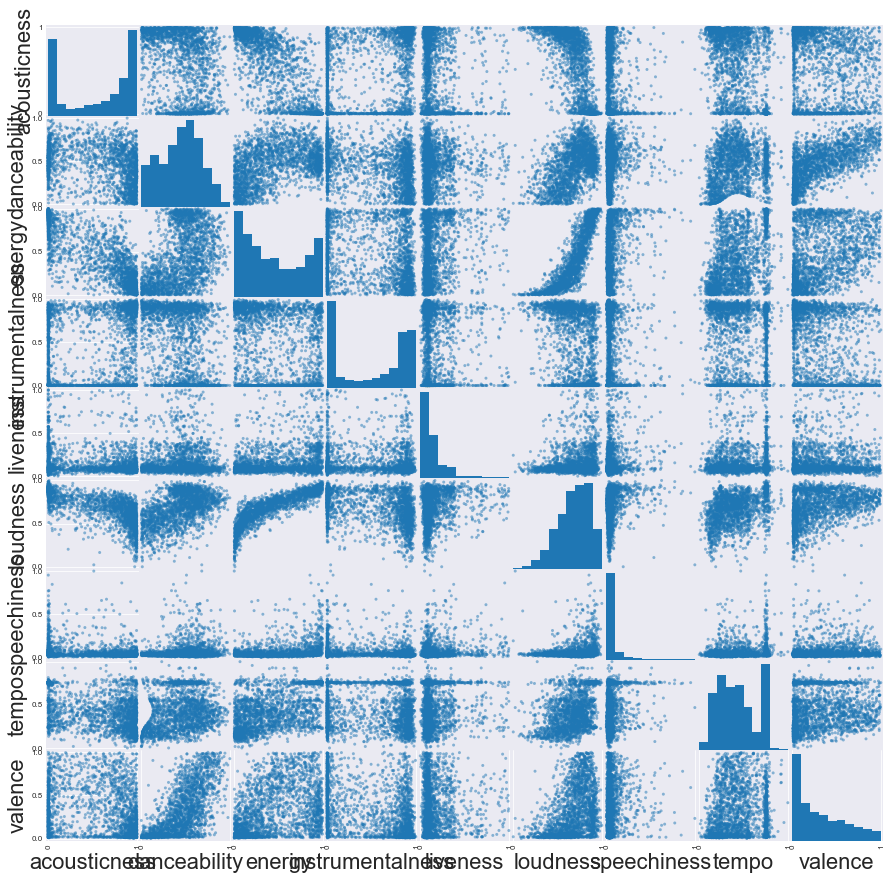

In [42]:
ss = StandardScaler()
#fs = pd.DataFrame(ss.fit_transform(features))
fs = pd.DataFrame(scaler.fit_transform(features))
fs.columns=['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
pd.plotting.scatter_matrix(fs, alpha=0.5, figsize=(15, 15))
plt.rc('font', size=15) 
plt.show()

Se puede apreciar que las distribuciones aun cuando estandarizadas, no tienden a la normal. Dibujemos los boxplot respectivos de cada variabla para identificar outliers:

In [43]:
#fs['loudness']=(fs.loudness.apply(lambda x:(x)**2) )
#fs['energy']=fs.energy.apply(lambda x:(x)**0.6)
#fs['liveness']=fs.liveness.apply(lambda x:(x)**0.3)
#fs['speechiness']=fs.speechiness.apply(lambda x:(x)**0.2)
#fs['valence']=(fs.valence.apply(lambda x:x**0.45))

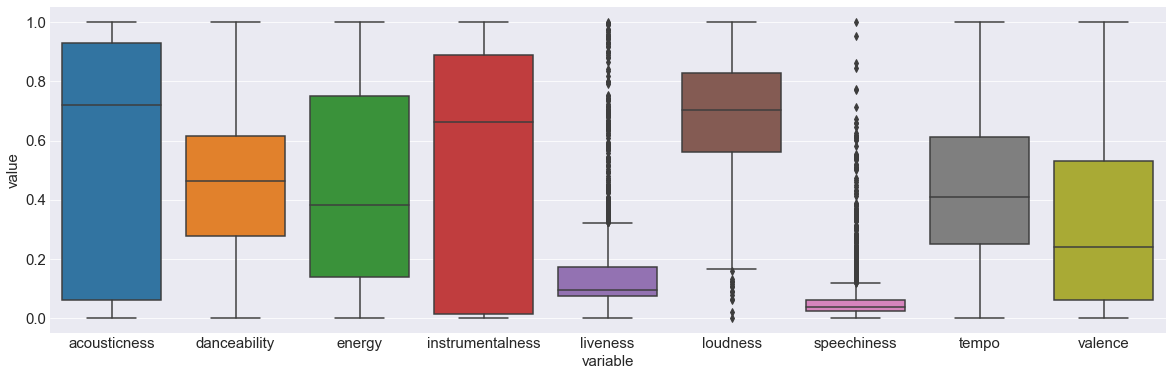

In [44]:
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(fs))

Podemos apreciar que las variables liveness, loudness y speechiness poseen una cantidad significativa de outliers

Procedemos a realizar el mismo analisis con la media delos datos de audio analisi estandarizados:

In [75]:
audio_median=[]
for i in audio_analysis:
    audio_median.append(i.median())
audio_median=pd.DataFrame(audio_median)

In [76]:
audio_mean=[]
for i in audio_analysis:
    audio_mean.append(i.mean())
audio_mean=pd.DataFrame(audio_mean)

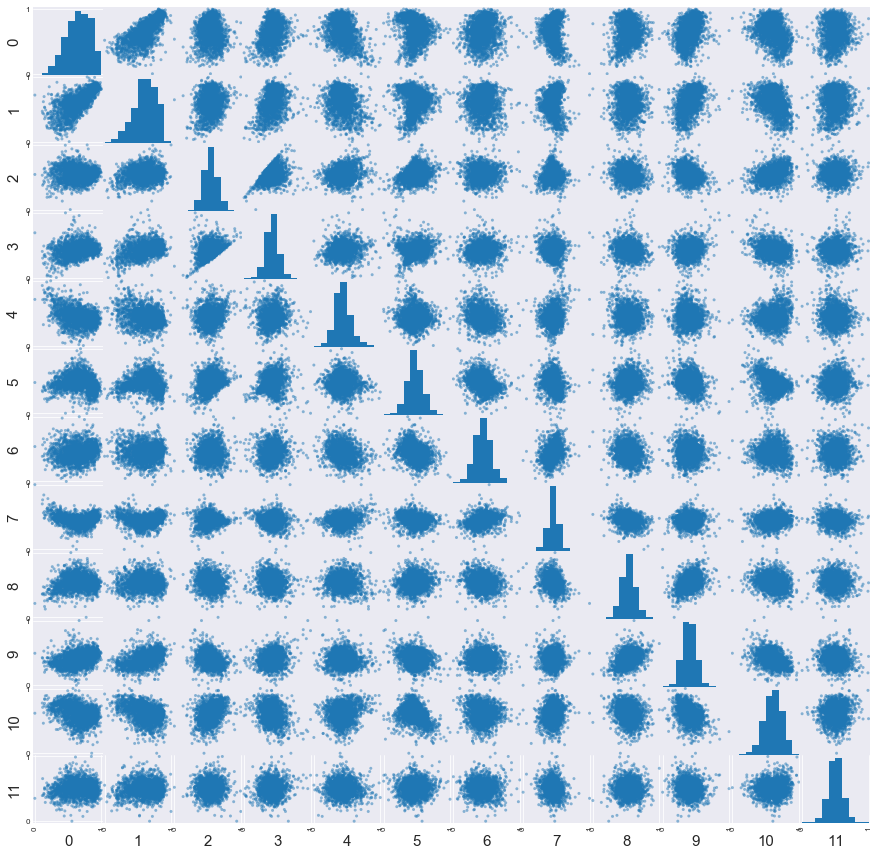

In [46]:
ss = StandardScaler()
#audio_mean_s=pd.DataFrame(ss.fit_transform(audio_mean))
audio_mean_s=pd.DataFrame(scaler.fit_transform(audio_mean))
pd.plotting.scatter_matrix(audio_mean_s, alpha=0.5, figsize=(15, 15))
plt.show()

Podemos observar que la distribucion de estos datos es bastante normal. Procedemos a al identificacion de outlieres mediante los boxplot:

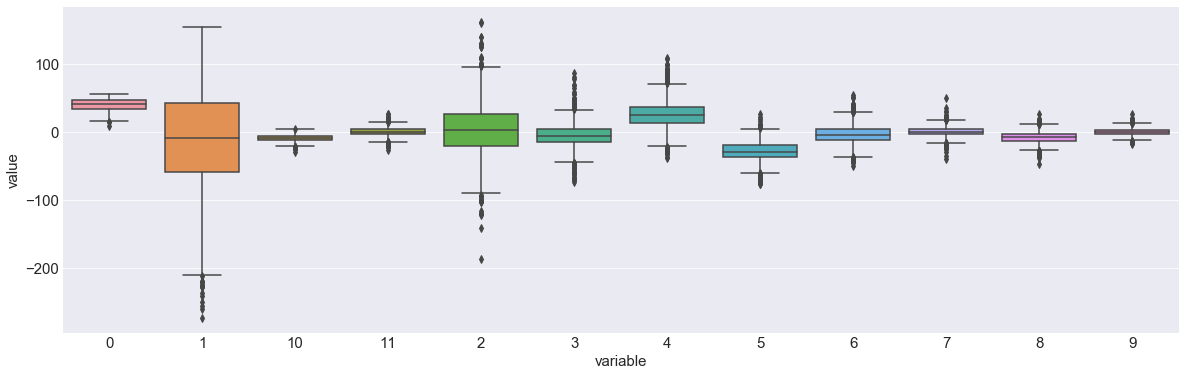

In [47]:
plt.figure(figsize=(20, 6))c
sns.boxplot(x="variable", y="value", data=pd.melt(audio_mean))

Podemos observar que existe una cantidad considerable de outliers para todas las variables estudiadas, lo que indica que existe una gran varianza entre los datos.

## Clustering

Para la clusterizacion de los datos, se implementaran distintos algoritmos con el objetivo de comparar la calida de los resultados. Cada uno de ellos contara con distintas etapas de implementacion.

Inicialmente uniremos las ambos daatsets para poder generar clusters tanto con cada uno por separado asi como juntos:

In [48]:
merge = pd.concat([fs, audio_mean_s], axis=1)
merge = merge.iloc[:-1,:]

Para elegir el numero optimo de clusters, tendremos en cuenta dos metricas: el coeficiente de silhouette y la suma de errores al cuadrado. La idea es observar como varian ambas metricas a medida que el numero de clusters incrementa, para asi poder elegir el numero optimo.

Inicialmente, definimos una funcion para calcular la suma de errores al cuadrado, es decir la suma al cuadrado de la distancia de cada punto al centroide de su cluster

In [49]:
def calculo_sse(labels,data,centers):
    sse = 0.
    for i in range(0,len(centers)):
        sse = sse + sum(np.power(cdist([centers[i]], data.iloc[labels== i,], 'euclidean')[0],2))
    return sse

Para efectos de validacion, tambien es necesario definir una funcion para calcular al medida de Van Dongen normalizada:

In [50]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

Luego, es necesario calcular las distancias de cada una de las canciones con las demas, para cada uno de los datasets para poder utilizar dichas distancias en el calculo del coeficiente de silhouette:

In [51]:
d_features = squareform(pdist(fs, 'euclidean'))
d_audio = squareform(pdist(audio_mean_s, 'euclidean'))
d_merge = squareform(pdist(merge, 'euclidean'))

Con estos datos procedemos a la implemetacion del primer algoritmo:

### Kmeans

Procedemos a calcular y graficar ambas metricas en funcion del numero de clusters para cada conjunto de datos utilizando este algoritmo:

In [52]:
kmax = 20
sil = []
sse = []
for i in range(2,kmax):   
    k = KMeans(n_clusters=i).fit(fs)
    sil.append(silhouette_score(fs, k.labels_))
    sse.append(calculo_sse(k.labels_, fs,k.cluster_centers_))

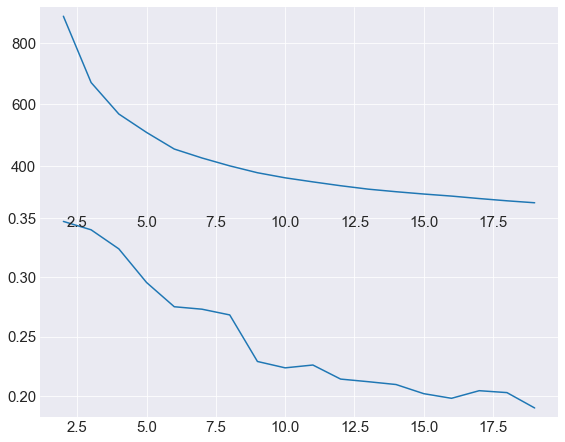

In [53]:
x = np.arange(2, kmax)
fig = pylab.figure()
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
plt.plot(x,sil)
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
plt.plot(x,sse)

In [54]:
kmax = 20
sil = []
sse = []
ss = []

for i in range(2,kmax):   
    k = KMeans(n_clusters=i).fit(audio_mean_s)
    sil.append(silhouette_score(audio_mean_s, k.labels_))
    sse.append(calculo_sse(k.labels_, audio_mean_s,k.cluster_centers_))
    ss.append(k.inertia_)

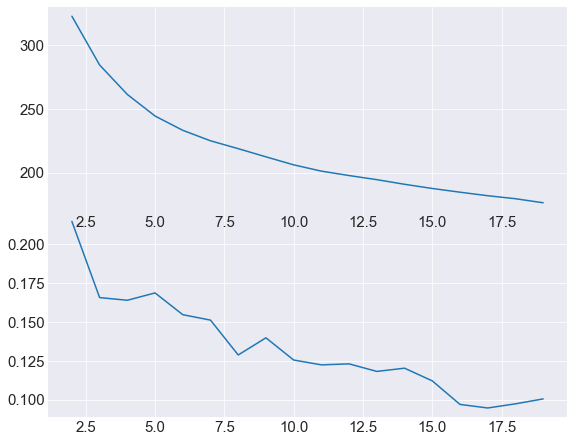

In [55]:
x = np.arange(2, kmax)
fig = pylab.figure()
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
plt.plot(x,sil)
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
plt.plot(x,sse)

In [56]:
kmax = 20
sil = []
sse = []
for i in range(2,kmax):   
    k = KMeans(n_clusters=i).fit(merge)
    sil.append(silhouette_score(merge, k.labels_))
    sse.append(calculo_sse(k.labels_, merge,k.cluster_centers_))

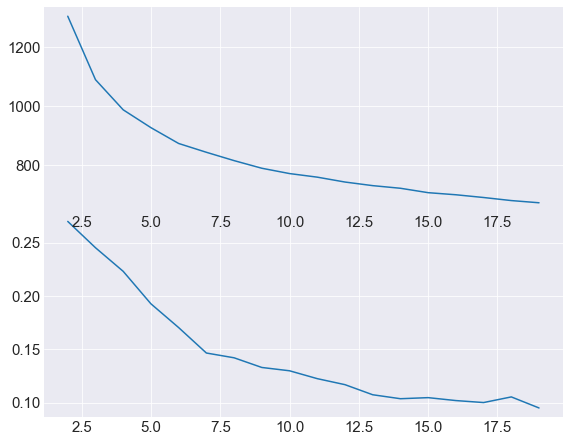

In [57]:
x = np.arange(2, kmax)
fig = pylab.figure()
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
plt.plot(x,sil)
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
plt.plot(x,sse)

Como se puede apreciar, el comportamiento es similar para los conjuntos de datos. Asi mismo, cuando el numero de cluster es cercano a 7, se observa un decaimiento de la pendiente de la curva del herror cuadratico y el final de una seccion plana del coeficiente de silhouette, por lo que se considera que este es el numero optimo de clusters para este algoritmo.

In [58]:
cluster_features = KMeans(n_clusters=7, random_state=0).fit(fs)
cluster_audio = KMeans(n_clusters=7, random_state=0).fit(audio_mean_s)
cluster_merge = KMeans(n_clusters=7, random_state=0).fit(merge)

Para evaluar cuan similares son los clusteres generaddos, a continuacion geraremos una matriz confusion a partir de los clusters generados por cada par de modelos, asi como el caculo del indice de Van Dogen, que mide cuan cerca estan de tener un solo elemento fila/columna, y finalmente el indice de Rand normalizado, que calcula la cantidad de individuos asignados al mismo cluster: 

In [59]:
tmp = pd.DataFrame({'features': cluster_features.labels_[:-1], 'audio':cluster_audio.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['features'], tmp['audio']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['features'], tmp['audio']))
ct0

Indice de Van Dongen: 1.0
Indice de Rand: -0.0005795987221717035


audio,0,1,2,3,4,5,6
features,,,,,,,
0,29,50,50,16,40,39,66
1,15,12,29,11,22,21,43
2,40,35,54,19,56,33,79
3,27,48,60,24,50,32,66
4,59,94,101,31,95,74,126
5,32,38,44,14,38,29,57
6,38,51,45,22,46,45,60


In [60]:
tmp = pd.DataFrame({'features': cluster_features.labels_[:-1], 'merge':cluster_merge.labels_})
ct0 = pd.crosstab(tmp['features'], tmp['merge'])
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['features'], tmp['merge']))
ct0

Indice de Van Dongen: 0.18583042973286876
Indice de Rand: 0.7170527570441986


merge,0,1,2,3,4,5,6
features,,,,,,,
0,2,0,0,6,280,0,2
1,23,82,0,0,1,21,26
2,0,1,310,5,0,0,0
3,0,295,10,0,0,2,0
4,341,0,0,0,1,0,238
5,20,0,0,2,0,197,33
6,0,0,0,302,2,3,0


In [61]:
tmp = pd.DataFrame({'audio': cluster_audio.labels_, 'merge':cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['audio'], tmp['merge']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['audio'], tmp['merge']))
ct0

Indice de Van Dongen: 0.9075701729515169
Indice de Rand: 0.041355628587993624


merge,0,1,2,3,4,5,6
audio,,,,,,,
0,0,36,39,40,28,25,72
1,66,56,34,52,50,40,30
2,108,77,53,45,51,45,4
3,0,26,20,26,13,5,47
4,7,58,58,50,36,31,107
5,50,38,35,44,40,27,39
6,155,87,81,58,66,50,0


Como se puede apreciar, los clusters generados con los datos de audio analisis son los que mas difieren de los demas, estando aquellos generados por ambos datos juntos y por los datos de audio features bastante cerca. Esto podria indicar que la informacion contenida por audio analisis no es relevante para la formacion de clusters, por consiguiente, los formados por los datos juntos toman pricipalmete los datos de audio features para la formacion.

A continuacion, se evaluara la coincidencia de estos clusteres con la columna de genero del archivo metadat:

In [62]:
tmp = pd.DataFrame({'genre': meta.genre, 'Clusters': cluster_features.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.6254081329771446
Indice de Rand: 0.25038119596209973


Clusters,0,1,2,3,4,5,6
genre,,,,,,,
ambient,32,116,9,33,210,58,2
classical,75,11,0,0,283,31,5
drum-and-bass,0,3,211,235,0,0,2
jazz,119,16,15,23,44,106,104
world-music,64,8,81,16,43,57,194


In [63]:
tmp = pd.DataFrame({'genre': meta.genre[:-1], 'Clusters': cluster_audio.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.9869565217391304
Indice de Rand: 0.00034905278462941404


Clusters,0,1,2,3,4,5,6
genre,,,,,,,
ambient,49,71,88,24,73,57,97
classical,39,60,66,25,76,54,85
drum-and-bass,47,61,90,32,76,39,106
jazz,46,67,72,31,59,49,103
world-music,59,69,67,25,63,74,106


In [64]:
tmp = pd.DataFrame({'genre': meta.genre[:-1], 'Clusters': cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.669194046616119
Indice de Rand: 0.2144113235806


Clusters,0,1,2,3,4,5,6
genre,,,,,,,
ambient,144,99,9,2,30,54,121
classical,175,0,0,6,75,20,129
drum-and-bass,0,228,221,2,0,0,0
jazz,36,30,13,106,117,95,30
world-music,31,21,77,199,62,54,19


Estos resultados coinciden con la conclusion obtenida de los anteriores, es decir, los atributos de bajo nive aportan poca informacion paara la frmacion de clusters y por consiguiente, estos no coinciden con las etiquetas de genero, a diferencia de los atributos de audio features. Para estos, se puede observar particularmente que los clusters 2 y 3 estan relacionados con el genro drums and bass, el cluster 4 con musica clasica y de ambientey el cluster 6 con jazz y world-music

Para poder visualizar mejor la asignacion de cada cancion a los clusters y como esta se compara con el genero al que pertenece, a continuacion se implementara una reduccion de dimensionalidad de los datos originales a dos dimensiones con la tecnica UMAP y se graficara un scatter plot sobre estas:

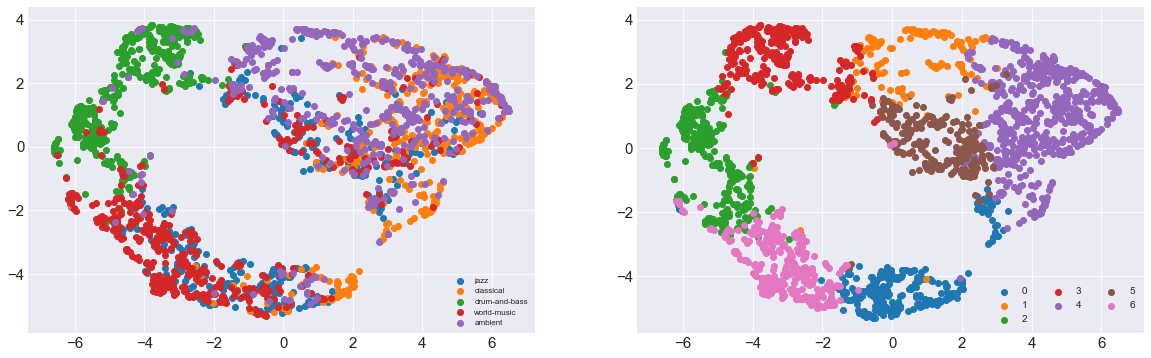

In [65]:
um = UMAP()
Xred = um.fit_transform(fs)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_features.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_features.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

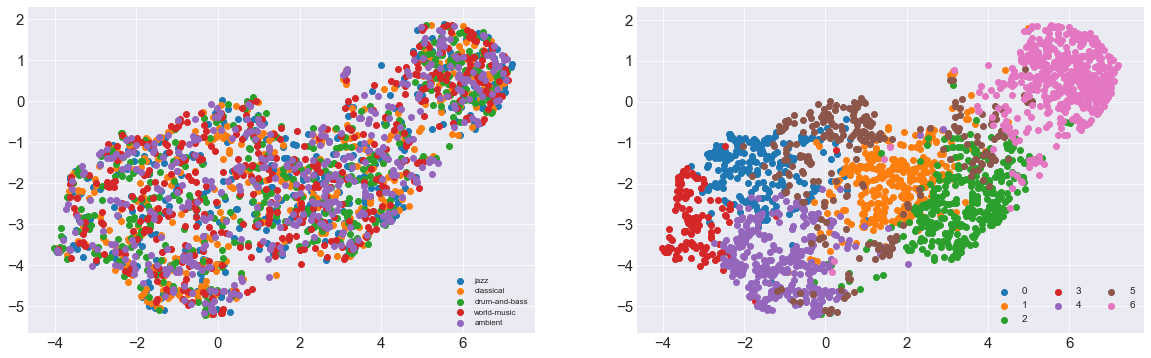

In [66]:
um = UMAP()
Xred = um.fit_transform(audio_mean_s)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_audio.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre[:-1]== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_audio.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

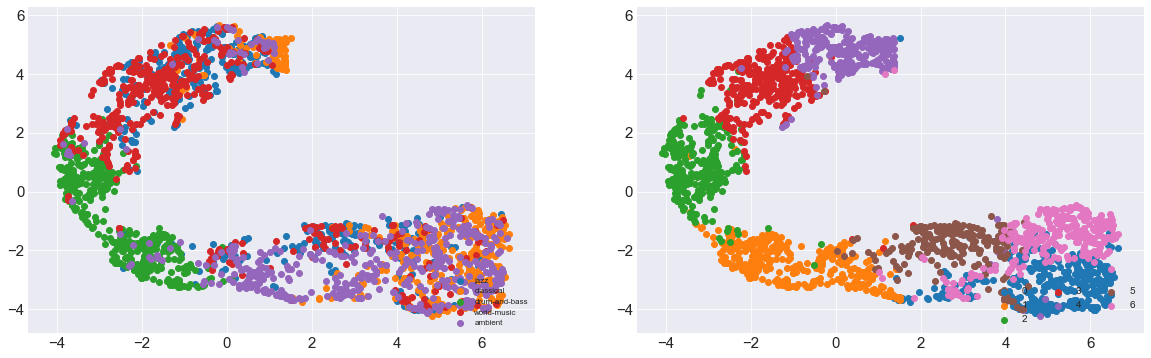

In [67]:
um = UMAP()
Xred = um.fit_transform(merge)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_merge.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre[:-1]== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_merge.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

La representacion grafica nos confirma las percepciones previas: no es claro diferenciar el genero de las canciones a partir de los datos disponibles en audio analysis, pues como puede apreciarse, se superponen datos de distintas etiquetas por lo que los clusters generados no corresponden a los generos. Por otro lado, a aprtir de audio features, se genera una separacion considerable de las canciones por genero, en donde esposile clusterizar acorde, y gracias a esto, los clusters corresponden mas a los generos. Los datos mezclados son un punto intermedio en donde se superponen los generos pero es posible apreciar cierta separacion. Es ademas posible ver como coinciden los clusters generados en audio features con algunos generos como se habia descubierto previamente, tales como el cluster 6 y el genero ambient y classical o el cluster 3 con el genero drums-bass.

## DBSCAN

El metodo DBSCAN es un metodo basado en densidades para encontrar separaciones de clusters de datos unidos por densidad de datos en sus areas cercanas y separando clusters de densidades distintas.
Su fortaleza es que no necesita que los clusters se encuentren dispersos en forma de globulos por lo que no importa la forma que tengan pero le cuesta separar cluster que se encuetran fusionados entre si en el espacio.
Utiliza el hiperparametro Epislon para definir el radio de busqueda y la min_sample que es la cantidad de datos minima que busca. Cualquier punto que dentro de su Epsilon tengo al menos min_sample se lo clasifica como Core Point. De esta forma los Core Points que aparescan dentro del radio de otros Core Point se los clasifica en el mismo Cluster. Los datos que esten en rango de un Core Point pero no cumplan con el min_sample de datos cercanos se los clasifica como Border Point y tambien pertencen al Cluster. Pero si un dato no es Core Point ni esta cerca de uno se lo clasifica como Outer Point y es un oulier para este modelo.
Otra desventaja de este modelo es la complejidad que requiere el ajuste de sus parametros por lo que para tener una idea de que valores de epsilon y min_sample nos estamos manejando haremos el grafico del ranking de la distancia de cada dato al N vecino para ver las distancias que generan los outliers. Realizamos exaustivos sondeo para el elegir el rango N a testear pero llegamos a la conclusion que los N de bajos valores dan los mejores resultados.


In [30]:
d_features = squareform(pdist(fs, 'euclidean'))
d_audio = squareform(pdist(audio_mean_s, 'euclidean'))
d_merge = squareform(pdist(merge, 'euclidean'))

In [ ]:
a=[]
f=plt.figure(figsize=(16, 6))
ax=f.add_subplot(111)
ax.yaxis.tick_right()
sns.set_style("darkgrid")
for i in range(22):
#   a.append(np.sort(np.sort(d_features)[:,i*22]))
    a.append((pd.DataFrame(np.sort(d_features)))[i*100].sort_values())
    sns.lineplot(data=a[i].values).set(xlim=(1000,2205),yticks=(list(np.arange(0,2.4,.2))),xticks=range(0,2250,150))
#   ax.legend(range(22),loc="center")

El grafico muestra la distancia al N vecino donde N = (1,10) y esta centrado la segunda mitad del dataset **Audio_Feature**. Vemos como a medida que aumentamos N la distancia Epsilon crece muy poco. De este grafico es importante ver el codo de la cola que se produce por los datos aislados del dataset, este valor nos da una sugerencia de epsilon a tomar para ese N o al menos una cota superior.

In [ ]:
a=[]
f=plt.figure(figsize=(16, 6))
ax=f.add_subplot(111)
ax.yaxis.tick_right()
sns.set_style("darkgrid")
for i in range(22):
#   a.append(np.sort(np.sort(d_features)[:,i*22]))
    a.append((pd.DataFrame(np.sort(d_audio)))[i*100].sort_values())
    sns.lineplot(data=a[i].values).set(xlim=(1000,2205),yticks=(list(np.arange(0,1.8,.2))),xticks=range(0,2250,150))
#   ax.legend(range(22),loc="center")

El grafico muestra la distancia al N vecino donde N = (1,10) y esta centrado la segunda mitad del dataset **Audio Mean**. Vemos como a medida que aumentamos N la distancia Epsilon crece muy poco. De este grafico es importante ver el codo de la cola que se produce por los datos aislados del dataset, este valor nos da una sugerencia de epsilon a tomar para ese N o al menos una cota superior.

In [ ]:
a=[]
f=plt.figure(figsize=(16, 6))
ax=f.add_subplot(111)
ax.yaxis.tick_right()
sns.set_style("darkgrid")
for i in range(22):
#   a.append(np.sort(np.sort(d_features)[:,i*22]))
    a.append((pd.DataFrame(np.sort(d_merge)))[i*100].sort_values())
    sns.lineplot(data=a[i].values).set(xlim=(2000,2205),yticks=(list(np.arange(0,2.5,.2))),xticks=range(0,2250,15))
#   ax.legend(range(22),loc="center")

El grafico muestra la distancia al N vecino donde N = (1,10) y esta centrado la segunda mitad del dataset **Merge**. Vemos como a medida que aumentamos N la distancia Epsilon crece muy poco. De este grafico es importante ver el codo de la cola que se produce por los datos aislados del dataset, este valor nos da una sugerencia de epsilon a tomar para ese N o al menos una cota superior.

En base a estos gráficos probamos varios Epsilons menres al codo generado por los outliers de cada dataset y probamos combinaciones distintas de min_sample y epsilon buscando solo los casos que generan entre 2 y 10 clusters y no poseen mas de 100 outliers. El objetivo de estas condiciones es obvservar solo los que tienen sentido con respecto a las clasificaciones iniciales que tenemos en la metadata, los 5 generos.
También en caso de conseguir muchas combinaciones con estas caracteristicas nos quedaremos con la de mayor Silouette score. Hay que tener en cuenta que Silouette es una metrica diseñada para evaluar clusters convexos y de forma globular.

In [ ]:
sil = []
for i in range(2,10):
    a=fs.copy()
    dbscan= DBSCAN(eps=0.45, metric='euclidean', min_samples=i)
    dbscan.fit(a)
    label=(dbscan.labels_)
    ncluster=len(set(label))-(1 if -1 in label else 0)
    if ncluster>1 and ncluster<10 and label[label==-1].sum() >-100:
        sil.append(silhouette_score(a, label))
        print("Sillout",sil,"cluster", ncluster, "min_sam", i, "outliers", label[label==-1].sum())
plt.plot(sil)
plt.xticks(range(0,10,1));

In [ ]:
sil = []
n=[]
for i in range(0,10):   
    a=audio_mean_s.copy()
    dbscan= DBSCAN(eps=0.34, metric='euclidean', min_samples=i)
    dbscan.fit(a)
    label=(dbscan.labels_)
    ncluster=len(set(label))-(1 if -1 in label else 0)
    if ncluster>1 and ncluster<10 and label[label==-1].sum() >-100:
        sil.append(silhouette_score(a, label))
        print("Sillout",sil,"cluster", ncluster, "min_sam", i, "outliers", label[label==-1].sum())
plt.plot(sil)
plt.xticks(range(0,10,1));

In [ ]:
sil = []
n=[]
for i in range(0,10):   
    a=merge.copy()
    dbscan= DBSCAN(eps=0.65, metric='euclidean', min_samples=i)
    dbscan.fit(a)
    label=(dbscan.labels_)
    ncluster=len(set(label))-(1 if -1 in label else 0)
    if ncluster>1 and ncluster<10 and label[label==-1].sum() >-100:
        sil.append(silhouette_score(a, label))
        print("Sillout",sil,"cluster", ncluster, "min_sam", i, "outliers", label[label==-1].sum())
plt.plot(sil)
plt.xticks(range(0,10,1));

In [ ]:
Nos quedamos con los siquigentes hiperparametros para cada dataset y procedemos a realizar los estudios de validacón externa:

In [ ]:
cluster_features = DBSCAN(eps=0.45, metric='euclidean', min_samples=3).fit(fs)
cluster_audio = DBSCAN(eps=0.34, metric='euclidean', min_samples=3).fit(audio_mean_s)
cluster_merge = DBSCAN(eps=0.65, metric='euclidean', min_samples=3).fit(merge)

In [ ]:
tmp = pd.DataFrame({'features': cluster_features.labels_[:-1], 'audio':cluster_audio.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['features'], tmp['audio']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['features'], tmp['audio']))
ct0

In [ ]:
tmp = pd.DataFrame({'features': cluster_features.labels_[:-1], 'merge':cluster_merge.labels_})
ct0 = pd.crosstab(tmp['features'], tmp['merge'])
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['features'], tmp['merge']))
ct0

In [ ]:
tmp = pd.DataFrame({'audio': cluster_audio.labels_, 'merge':cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['audio'], tmp['merge']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['audio'], tmp['merge']))
ct0

In [ ]:
tmp = pd.DataFrame({'audio': cluster_audio.labels_, 'merge':cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['audio'], tmp['merge']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['audio'], tmp['merge']))
ct0

In [ ]:
tmp = pd.DataFrame({'genre': meta.genre, 'Clusters': cluster_features.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

In [ ]:
tmp = pd.DataFrame({'genre': meta.genre[:-1], 'Clusters': cluster_audio.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

In [ ]:
tmp = pd.DataFrame({'audio': cluster_audio.labels_, 'merge':cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['audio'], tmp['merge']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['audio'], tmp['merge']))
ct0

In [ ]:
tmp = pd.DataFrame({'genre': meta.genre[:-1], 'Clusters': cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

In [ ]:
um = UMAP()
Xred = um.fit_transform(fs)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_features.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_features.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

In [ ]:
um = UMAP()
Xred = um.fit_transform(audio_mean_s)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_audio.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre[:-1]== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_audio.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

In [ ]:
um = UMAP()
Xred = um.fit_transform(merge)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_merge.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre[:-1]== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_merge.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()

Los resultados muestran que este algoritmo no supervisado no pude separar satisfactoriamente los datos en clusters asemejados con sus generos. Esto se puede deber a que los datos se estan demasiados fusionados entre si para ser separados por un metodo de densidad.

Analizaremos el impacto que tendria tomar la mediana de los audio analysis en vez de la media. La mediana es una medida robusta a diferencia de la media y como en este dataset podemos visulizar gran cantidad de outliers, esperamos un resultado distinto en el analisis de este dataset.

In [77]:
audio_median=[]
for i in audio_analysis:
    audio_median.append(i.median())
audio_median=pd.DataFrame(audio_median)

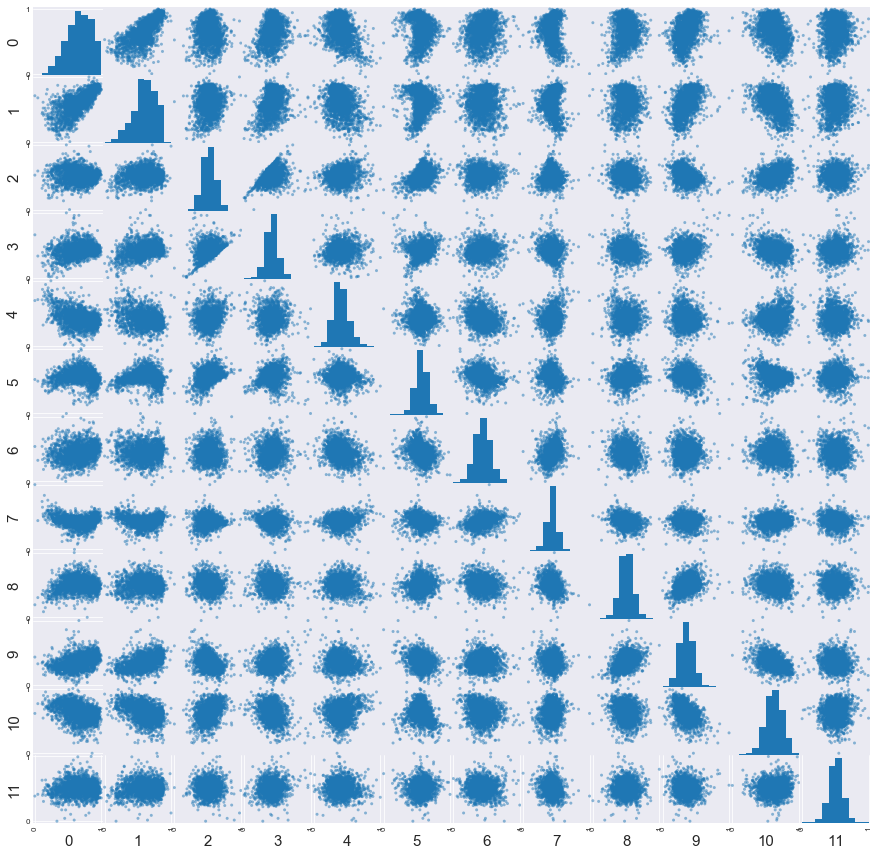

In [87]:
ss = StandardScaler()
#audio_mean_s=pd.DataFrame(ss.fit_transform(audio_mean))
audio_median_s=pd.DataFrame(scaler.fit_transform(audio_median))
pd.plotting.scatter_matrix(audio_mean_s, alpha=0.5, figsize=(15, 15))
plt.show()

Debido al Teorema Central de Limite vemos que el resumen de los datos tienen distribucion normal nuevamente.

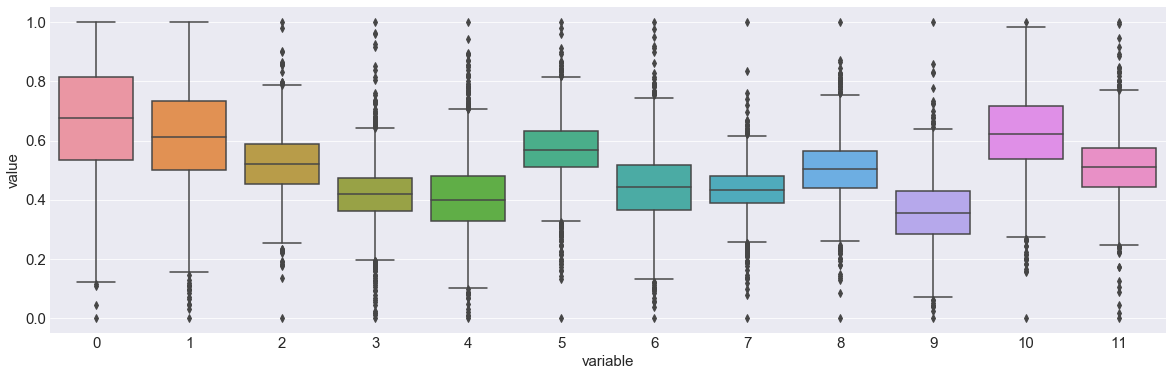

In [88]:
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(audio_median_s))

Obervamos una varianza superior al resumir los datos mediante la mediana.

In [106]:
kmax = 20
sil = []
sse = []
for i in range(2,kmax):   
    k = KMeans(n_clusters=i).fit(audio_median_s)
    sil.append(silhouette_score(audio_median_s, k.labels_))
    sse.append(calculo_sse(k.labels_, audio_median_s,k.cluster_centers_))

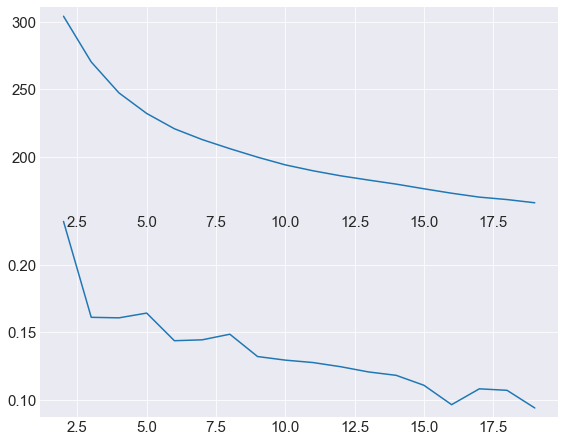

In [107]:
x = np.arange(2, kmax)
fig = pylab.figure()
axsil = fig.add_axes([0.05,0.05,0.9,0.475])
plt.plot(x,sil)
axsse = fig.add_axes([0.05,0.525,0.9,0.475])
plt.plot(x,sse)

Aca podemos ver la primera diferencia importante, el grafico de Silouete nos sugeriria elegir un K means de 5 o 8 antes que elegir nuevamente 7 clusters. En este caso vamos a elegir un cluster de 8.

In [117]:
cluster_audiom = KMeans(n_clusters=8, random_state=0).fit(audio_mean_s)


In [118]:
tmp = pd.DataFrame({'features': cluster_features.labels_[:-1], 'audio':cluster_audiom.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['features'], tmp['audio']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['features'], tmp['audio']))
ct0

Indice de Van Dongen: 0.9976211715730003
Indice de Rand: -0.0012935299248276594


audio,0,1,2,3,4,5,6,7
features,,,,,,,,
0,8,41,21,57,44,15,61,43
1,1,29,8,31,21,8,44,11
2,12,35,27,64,56,18,74,30
3,6,38,23,64,46,21,66,43
4,22,71,47,121,85,32,117,85
5,8,33,19,53,39,12,49,39
6,11,46,37,49,43,14,56,51


In [119]:
tmp = pd.DataFrame({'audio': cluster_audiom.labels_, 'merge':cluster_merge.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['audio'], tmp['merge']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['audio'], tmp['merge']))
ct0

Indice de Van Dongen: 0.9094742760753444
Indice de Rand: 0.0401783528011692


merge,0,1,2,3,4,5,6
audio,,,,,,,
0,23,7,12,11,8,7,0
1,39,49,37,45,42,31,50
2,0,25,28,41,19,11,58
3,128,83,63,48,59,54,4
4,6,53,57,47,41,32,98
5,0,23,18,17,12,5,45
6,145,89,76,55,60,42,0
7,45,49,29,51,43,41,44


In [120]:
tmp = pd.DataFrame({'genre': meta.genre[:-1], 'Clusters': cluster_audio.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['genre'], tmp['Clusters']) # Crear una matriz de confusion: ct
print('Indice de Van Dongen:',vanDongen(ct0))
print('Indice de Rand:',adjusted_rand_score(tmp['genre'], tmp['Clusters']))
ct0

Indice de Van Dongen: 0.9873271889400922
Indice de Rand: 0.00033171176967588937


Clusters,0,1,2,3,4,5,6
genre,,,,,,,
ambient,98,43,26,85,76,77,54
classical,78,39,29,72,59,78,50
drum-and-bass,101,42,35,90,61,79,43
jazz,99,48,32,82,60,63,43
world-music,99,49,25,68,77,69,76


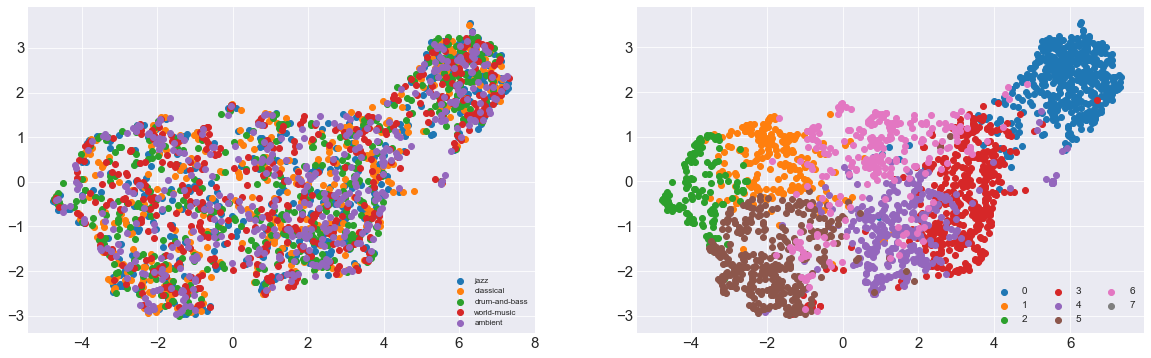

In [121]:
um = UMAP()
Xred = um.fit_transform(audio_median_s)
l = meta.genre.unique().tolist()
l2 = list(set(cluster_audiom.labels_.tolist()))
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 6))
for g in l:
    ix = np.where(meta.genre[:-1]== g)
    ax[0].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g)
for g in l2:
    ix = np.where(cluster_audio.labels_== g)
    ax[1].scatter(Xred[:,0][ix], Xred[:,1][ix], label = g )
ax[1].legend(ncol=3, fontsize=10, loc='lower right')
ax[0].legend(ncol=1, fontsize=8, loc='lower right')
plt.show()